In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import time
import os
from skimage import data
from skimage import filters
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io, morphology
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.metrics import confusion_matrix

cv.__version__

'4.8.0'

In [ ]:
#Setting filepaths

template_path = '/content/drive/MyDrive/results/template.jpg' # path to save generated template for OD localization
directory_path ="/content/drive/MyDrive/ results/a. Training Set/"  # path where images are stored
#save_path = 'C:/Users/NILAVINI/OneDrive/Desktop/DL PROJECT/result' # path to save OD localization results
save_path='/content/drive/MyDrive/ results'
if not os.path.exists(save_path):
   os.mkdir(save_path)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Error: Template image was not saved.


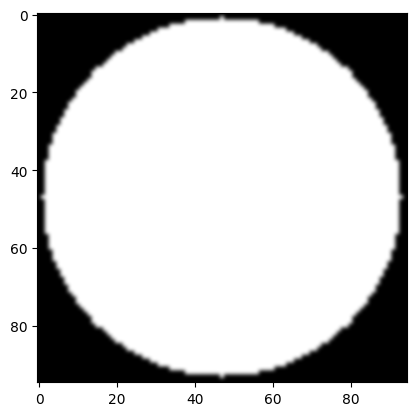

In [ ]:
#Template creation
template = np.ones((95,95), dtype="uint8") * 0
template = cv.circle(template, (47,47), 46, 255, -1)
print(template)
plt.imshow(template, cmap = 'gray', interpolation = 'bicubic')
cv.imwrite(template_path, template)
if os.path.exists(template_path):
    print("Template image saved successfully at:", template_path)
else:
    print("Error: Template image was not saved.")

In [ ]:
def getImage(img_num):
  path = directory_path
  str_num = str(img_num)
  if (img_num) < 10:
    str_num = '0'+ str_num
  name = 'IDRiD_0' + str_num + '.jpg'
  full_path = path + name
  image = cv.imread(full_path, -1)
  #print(full_path)
  return image

In [ ]:
def imgResize(img):
  h = img.shape[0]
  w = img.shape[1]
  perc = 500/w
  w1 = 500
  h1 = int(h*perc)
  img_rs = cv.resize(img,(w1,h1))
  #print(h,w,w1,h1)
  #h=2848 w= 4288  w1=500 h1=332
  return img_rs

In [ ]:
import pandas as pd
predicted_x=[]
predicted_y=[]
def getOriginalCoordinates(resized_x, resized_y):
    original_width=4288
    original_height=2848

    # Calculate the resizing factor
    resizing_factor = original_width / 500  # Assuming the image was resized to have a width of 500 pixels

    # Scale the resized coordinates back to the original image size
    original_x = int(resized_x * resizing_factor)
    original_y = int(resized_y * resizing_factor)
    print(original_x,original_y)
    predicted_x.append(original_x)
    predicted_y.append(original_y)
predicted_XY=pd.DataFrame()
predicted_XY['Xcoord']=predicted_x
predicted_XY['Ycoord']=predicted_y

In [ ]:
def cannyEdges(img, th1, th2):
  edges = cv.Canny(img, th1, th2)
  return edges

In [ ]:
def kmeansclust(img, k, attempts, max_iter, acc, use = 'OD'):

  if use == 'OD':
    img_rsp = img.reshape((-1,1))
  else :
    img_rsp = img.reshape((-1,3))

  img_rsp = img_rsp.astype('float32')


  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, acc)
  _, labels, (centers) = cv.kmeans(img_rsp, k, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)
  centers = centers.astype('uint8')

  labels = labels.flatten()
  seg_img = centers[labels.flatten()]
  seg_img = seg_img.reshape(img.shape)
  return seg_img

Image Number:  1
315 200
2701 1715
Image Number:  2
111 134
951 1149
Image Number:  3
105 135
900 1157
Image Number:  4
148 144
1269 1234
Image Number:  5
312 268
2675 2298
Image Number:  6
77 151
660 1294
Image Number:  7
367 147
3147 1260
Image Number:  8
109 102
934 874
Image Number:  9
355 129
3044 1106


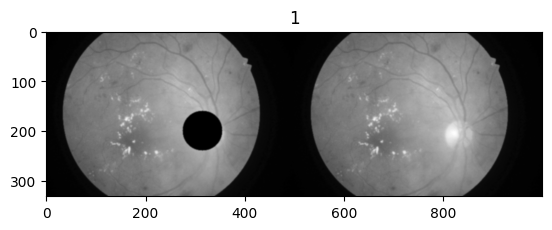

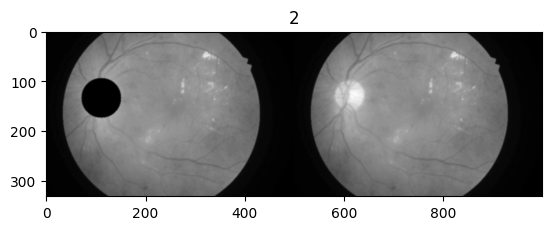

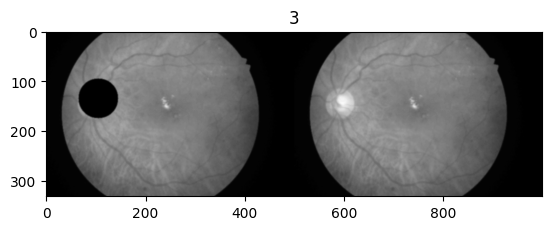

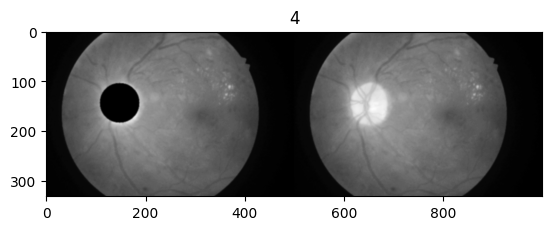

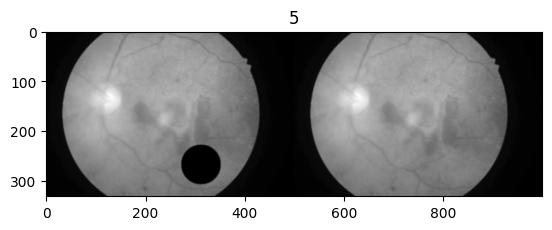

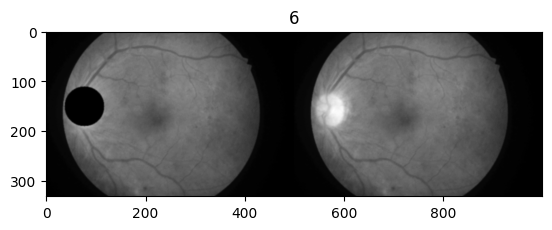

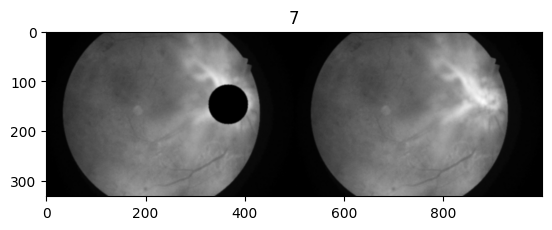

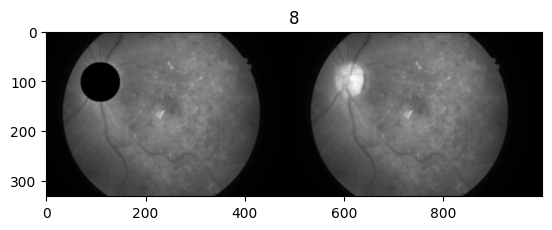

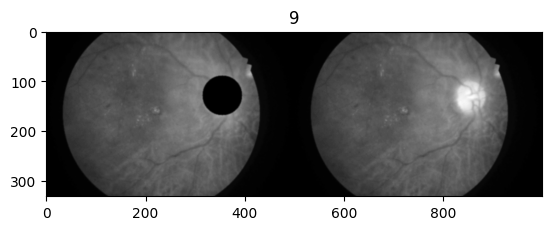

In [ ]:
 #Optic Disc Localization

i = 0
count = 0
start_time = time.time()

for img_num in range(1,10):
  img = getImage(img_num)
  print("Image Number: ", img_num)

  img_rs = imgResize(img)

  img_grey = cv.cvtColor(img_rs, cv.COLOR_BGR2GRAY)


  img_k = kmeansclust(img_grey, 7, 10, 400, 0.99)


  #temp = cv.imread(template_path, -1)
  temp=template
 # print(temp.shape[0],temp.shape[1])

  #TEMPLATE MATCHING
  metd = cv.TM_CCOEFF_NORMED
  temp_mat = cv.matchTemplate(img_k, temp, metd)

  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(temp_mat)
  x = max_loc[0]+45
  y = max_loc[1]+45
  print(x,y)


  getOriginalCoordinates(x,y)
  temp_mat = img_grey.copy()
  img_mark = cv.circle(temp_mat, (x, y) ,40, 0, -1)

  if (img_num<10):
    img_path = save_path + "0" + str(img_num) +'.jpg'
  else:
    img_path = save_path + str(img_num) +'.jpg'
  cv.imwrite(img_path, img_mark)

  img_stack = np.hstack([img_mark, img_grey])

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(img_stack, cmap = 'gray', interpolation = 'bicubic')



  i = i + 1

end_time = time.time()

In [ ]:
print(predicted_x)
print(predicted_y)

[2701, 951, 900, 1269, 2675, 660, 3147, 934, 3044]
[1715, 1149, 1157, 1234, 2298, 1294, 1260, 874, 1106]


In [ ]:
predicted = pd.DataFrame(list(zip(predicted_x, predicted_y)),
               columns =['Xcoord', 'Ycoord'])

In [ ]:
predicted

,Xcoord,Ycoord
0,2701,1715
1,951,1149
2,900,1157
3,1269,1234
4,2675,2298
5,660,1294
6,3147,1260
7,934,874
8,3044,1106


In [ ]:
import pandas as pd
import numpy as np

# Load the ground truth data
ground_truth_df = pd.read_csv('/content/drive/MyDrive/ results/a. IDRiD_OD_Center_Training Set_Markups.csv')
ground_truth_df= ground_truth_df.head(11)
# Load the predicted data

# Calculate the Euclidean distance between each pair of predicted and ground truth coordinates
distances = np.sqrt((predicted['Xcoord'] -  ground_truth_df['X- Coordinate'])**2 + (predicted['Ycoord'] - ground_truth_df['Y - Coordinate'])**2)
print(distances)
# Define a threshold distance for considering a prediction as correct
threshold_distance = 100  # Adjust as needed

# Count the number of correct predictions
num_correct_predictions = (distances < threshold_distance).sum()

# Calculate the total number of predictions
total_predictions = ground_truth_df.shape[0]

# Calculate the accuracy
accuracy = num_correct_predictions / total_predictions

print("Accuracy:", accuracy)


0      180.966848
1       31.048349
2      164.878743
3       55.036352
4     1973.079826
5      102.078401
6      311.977563
7       19.235384
8       60.827625
9             NaN
10            NaN
dtype: float64
Accuracy: 0.36363636363636365


exudates


In [ ]:
def getContours1(img, img_main, cnt_area):
  mask1 = np.ones(img.shape, dtype="uint8") * 0
  cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
  for i in cnts0:
    if cv.contourArea(i) <= cnt_area:
      cv.drawContours(mask1, [i], -1, 255, -1)
  mask1 = cv.bitwise_and(img_main, img_main, mask = mask1)
  return mask1

In [ ]:
#Detection of Exudates

acc = []
spcf = []
sens = []
f1_sc = []
i = 0
count = 0
img_num = 1
for img_num in range(1, 11):


  print("Image Number: ", img_num)

  if (img_num<10):
    str_num = "0" + str(img_num)
  else:
    str_num = str(img_num)
  file_path = save_path + str_num +'.jpg'
  img_mark = cv.imread(file_path, -1)



  # Read the image from file
  img = getImage(img_num)
  img = imgResize(img)


  # Splitting channels
  _, img_gc, _ = cv.split(img)


  # Large Exudates
  clus_seg = kmeansclust(img, 8, 5, 20, 0.69, use = 'EX')
  clus_seg = cv.cvtColor(clus_seg, cv.COLOR_BGR2GRAY)
  unique, counts = np.unique(clus_seg, return_counts=True)
  _,kthm = cv.threshold(clus_seg, np.max(unique)-1, 255, cv.THRESH_BINARY)


  # Small Exudates
  edges = cannyEdges(img_gc, 70, 120)
  img_cnt = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
  img_clean = getContours1(img_cnt, img_gc, 15)
  img_clean = cv.erode(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations=1)
  img_clean = cv.dilate(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations = 2)
  max_intsy = np.max(img_clean.flatten())
  img_clean[img_clean>=max_intsy] = 255
  img_clean[img_clean<max_intsy] = 0
  _, img_clean = cv.threshold(img_clean, 173, 255, cv.THRESH_BINARY)


  img_final = cv.bitwise_or(kthm, img_clean)

  #Masking Optic Disc
  img_final[img_mark==0] = 0

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(np.hstack([cv.cvtColor(img, cv.COLOR_RGB2BGR), cv.cvtColor(img_final, cv.COLOR_GRAY2BGR)]))